## Statistical Tests on Math Students dataset 

1. Chi-Square Test of Indepedence
2. One-way ANOVA test for Variance Comparison

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import plotly.express as px

ModuleNotFoundError: No module named 'plotly'

listing out all the column names

In [2]:
data_mat = pd.read_csv("../artifacts/raw/middle-student-mat.csv",sep=";")
data_mat.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


Due to the large number of attributes, we narrowed our scope to focus on features that are uncontrollable by students (i.e. Students inherent background). These features include:

- School
- Sex
- Age
- Address
- Famsize (Family Size)
- Pstatus (Parent's Cohabitation Status)
- Medu (Mother's Education)
- Fedu (Father's Education)
- Mjob (Mother's Job)
- Fjob (Father's Job)
- Reason (Reason to choose this school)
- Nursery (attended nursery school)


In [4]:
independent_feat = ['school','sex','age','address','famsize','Pstatus','Medu','Fedu','Mjob', 'Fjob','reason','nursery']
independent_feat

['school',
 'sex',
 'age',
 'address',
 'famsize',
 'Pstatus',
 'Medu',
 'Fedu',
 'Mjob',
 'Fjob',
 'reason',
 'nursery']

In [5]:
dependent_feat = ['G3']
dependent_feat

['G3']

In [6]:
# unique values for age
data_mat['age'].unique()

array([18, 17, 15, 16, 19, 22, 20, 21], dtype=int64)

## 1. Testing for correlation between Independent variables

Before performing correlation between independent and dependent variables, we will need to test that the independent variables are truly independent of each other.

We will use Chi Square test for Independence to verify this for categorical variables. Most of the variables are already categorical data except for `Age`. However, there are only 8 unique values for `Age` hence we will treat `Age` as a categorical variable for the test of independence.

- Null Hypothesis: There is **no relationship** between the 2 variables
- Alternate Hypothesis: There is **a relationship** betwen the 2 variables

In [7]:
import scipy.stats as stats

In [8]:
def calculate_chi_square_results(features, df):
    """
    Calculates chi-square test results for all possible pairs of features in a given data matrix.
    
    Parameters:
        independent_feat (list): List of feature names to compare
        data_mat (pandas.DataFrame): Data matrix containing the features
    
    Returns:
        chi_sqr_res_lst (list): List of dictionaries containing chi-square test results for each pair of features
    """
    chi_sqr_res_lst = []  # Initialize an empty list to store the results
    
    # Loop over all possible pairs of features
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            # Calculate crosstabulation for the two features
            crosstab = pd.crosstab(df[features[i]],df[features[j]])
            # Perform chi-square test on the crosstabulation
            res = stats.chi2_contingency(crosstab)
            # Store the results in a dictionary
            results_dict = {
                'variables': (features[i], features[j]),
                'pvalue': res.pvalue,
                'statistics': res.statistic,
                'dof': res.dof,
                'expected_freq': res.expected_freq,
            }
            # Append the dictionary to the results list
            chi_sqr_res_lst.append(results_dict)
    
    return chi_sqr_res_lst

def print_significant_results(chi_sqr_res_lst):
    """
    Prints the variables and p-values for all significant chi-square test results in a list of results.
    A result is considered significant if its p-value is less than 0.05.
    
    Parameters:
        chi_sqr_res_lst (list): List of dictionaries containing chi-square test results for each pair of features
    
    Returns:
        None
    """
    count = 0
    data = {}
    # Loop over all results in the list
    for results in chi_sqr_res_lst:
        # Get the p-value and variables for the current result
        pvalue = float(results.get('pvalue'))
        variables = results.get('variables')
        
        # Check if the result is significant
        if pvalue < 0.05:
            # Print the variables and p-value, rounded to 4 decimal places
            print(variables, pvalue)
            count+=1

    if count == 0:
        print("There are no variables that have relationship with each other")

In [9]:
chi_sqr_res_lst = calculate_chi_square_results(features=independent_feat, df=data_mat)
dict_chisqr = print_significant_results(chi_sqr_res_lst)

AttributeError: 'tuple' object has no attribute 'pvalue'

Let's drop school, address, Fedu, Medu, Fjob and Pstatus and check for relationships using chi square again

In [9]:
new_categorical_feats = [feat for feat in independent_feat if feat not in ['school', 'address', 'Fedu', 'Medu','Mjob','Pstatus']]
new_categorical_feats

['sex', 'age', 'famsize', 'Fjob', 'reason', 'nursery']

In [10]:
new_chi_sqr_res_lst = calculate_chi_square_results(features=new_categorical_feats, df=data_mat)
print_significant_results(new_chi_sqr_res_lst)

There are no variables that have relationship with each other


With Chi Square Test of Independence, we can conclude that without the following features - school, address, Fedu, Medu, Fjob and Pstatus, the remaining features *('sex', 'age', 'famsize', 'Mjob', 'reason', 'nursery')* are independent of each other.

## 2. Split Features for T-Test and ANOVA

Dependeing of the number of sample groups within each categorical feature, that will determine if we should use ANOVA or t-test. Features with more than 2 sample groups will run ANOVA test, while features with 2 sample groups will be tested with t-test.

In [11]:
def split_features_by_test(df, feat_lst):
    """
    Splits the independent features of a dataset into two lists, one for t-tests and one for ANOVA.

    Parameters:
    df: a pandas DataFrame containing the dataset
    independent_feat: a list of the names of the independent features

    Returns:
    Two lists of the names of the independent features, one for t-tests and one for ANOVA.
    """

    # Initialize empty lists for the t-tests and ANOVA
    ttest_lst = []
    anova_lst = []

    # Loop through each column in the independent features
    for col in feat_lst:

        # Check the number of unique values in the column
        nuniques = df[col].nunique()

        # If there are more than 2 unique values, add the column to the list for ANOVA
        if nuniques > 2:
            anova_lst.append(col)

        # Otherwise, add the column to the list for t-tests
        else:
            ttest_lst.append(col)

    # Return the lists of independent features for t-tests and ANOVA
    return ttest_lst, anova_lst

In [12]:
# split the categorical independent features 
# note that we are treating AGE as a categorical feature
ttest_lst, anova_lst = split_features_by_test(data_mat, independent_feat)

## 3 Testing for Homogeneity of Variance

- Null Hypothesis: The distribution, or “spread,” of scores around the mean of two or more samples are **considered equal**.
- Alternative Hypothesis: The distribution, or “spread,” of scores around the mean of two or more samples are **not equal**.

In [13]:
from scipy.stats import levene

def calculate_levene_tests(unique_array_lst, feats):
    """
    Calculates the Levene test statistic and p-value for all possible number of sample groups.

    Parameters:
    unique_array_lst: a list of unique arrays to test. Length of array represents the number of sample groups. Minimum is 2.
    feats: the name of the feature being tested

    Returns:
    A list of dictionaries containing the results of the Levene tests.
    """
    
    # Loop through each possible combination of unique arrays
    for i in range(2, len(unique_array_lst) + 1):

        # Select the first i unique arrays from the list
        samples = unique_array_lst[:i]

        # Calculate the Levene test statistic and p-value for the selected samples
        stat, p = levene(*samples, center='median', proportiontocut=0.05)

        # Create a dictionary with the results of the Levene test
        levene_dict = {
            'feature': feats, # The name of the feature being tested
            'statistic': stat, # The calculated Levene test statistic
            'pvalue': p # The calculated p-value
        }

    # Return the list of Levene test results
    return levene_dict


In [66]:
def get_sample_groups(df, feat_lst, scores):
    """
    This function returns a list of dictionaries where each dictionary represents a feature in feat_lst
    and its corresponding sample groups as arrays. Each dictionary will contain list of arrays, with each array representing the score values for each sample group. 
    
    Args:
        df (pandas DataFrame): The data to be used for testing
        feat_lst (list): A list of feature names 
    
    Returns:
        list: A list of dictionaries representing each feature and its sample groups as arrays.
    """
    sample_groups_array_lst = []
    # Loop over each feature in ttest_lst
    for feat in feat_lst:
        # Get unique values of the current feature
        sample_groups = df[feat].unique()
        sample_group_array_lst = []
        sample_group_name_lst = []
        # Loop over each unique value and get the corresponding data points for that value
        for i in range(len(sample_groups)):
            df_sample_group = df.loc[df[feat] == sample_groups[i]]
            # Append the data points as an array to sample_group_array_lst
            sample_group_array_lst.append(df_sample_group[scores])
            # append sample group name to sample_group_name_lst
            sample_group_name_lst.append(sample_groups[i])
        
        # Create a dictionary to store the feature name and its corresponding sample groups as arrays
        feature_array_dict = {
            'feature': feat,
            'sample_group_name_lst': sample_group_name_lst,
            'sample_group_array_lst': sample_group_array_lst
        }
        # Append the dictionary to sample_groups_array_lst
        sample_groups_array_lst.append(feature_array_dict)
    
    return sample_groups_array_lst


### 3.1 Testing for Homogeneity of Variance for t-test features

In [67]:
# retrieving arrays of sample groups from features that will be tested using t-test 
ttest_sample_groups_array_lst = get_sample_groups(data_mat, ttest_lst, 'G3')

# run levene tests to determine if homogeneity of variance is satisfied
ttest_levene_res_lst = []
for item in ttest_sample_groups_array_lst:
    feat = item.get('feature')
    array_lst = item.get('sample_group_array_lst')

    levene_dict = calculate_levene_tests(array_lst, feat)
    ttest_levene_res_lst.append(levene_dict)

ttest_levene_res_lst

[{'feature': 'school',
  'statistic': 0.8377081603117896,
  'pvalue': 0.3606142973401584},
 {'feature': 'sex',
  'statistic': 0.06847571965446789,
  'pvalue': 0.7937062862303847},
 {'feature': 'address',
  'statistic': 0.039462285189423164,
  'pvalue': 0.8426383524673037},
 {'feature': 'famsize',
  'statistic': 1.062426470207238,
  'pvalue': 0.3032963295247042},
 {'feature': 'Pstatus',
  'statistic': 0.483787387888353,
  'pvalue': 0.48712285383963405},
 {'feature': 'nursery',
  'statistic': 0.22789022933888387,
  'pvalue': 0.6333579961143636}]

In [68]:
for item in ttest_levene_res_lst:
    if item.get('pvalue') < 0.05:
        print(f"{item.get('feature')}: student t-test")
    else:
        print(f"{item.get('feature')}: welch's t-test")

school: welch's t-test
sex: welch's t-test
address: welch's t-test
famsize: welch's t-test
Pstatus: welch's t-test
nursery: welch's t-test


We can see that all of the features for t-test here fail to meet the assumption of homogeneity of variance. We will go with Welch's t-test instead

### 3.2 Testing for Homogeneity of Variance for ANOVA features

In [69]:
# retrieving arrays of sample groups from features that will be tested using t-test 
anova_sample_groups_array_lst = get_sample_groups(data_mat, anova_lst, 'G3')

# run levene tests to determine if homogeneity of variance is satisfied
anova_levene_res_lst = []
for item in anova_sample_groups_array_lst:
    feat = item.get('feature')
    array_lst = item.get('sample_group_array_lst')

    levene_dict = calculate_levene_tests(array_lst, feat)
    anova_levene_res_lst.append(levene_dict)

anova_levene_res_lst

[{'feature': 'age',
  'statistic': 0.6184299930183529,
  'pvalue': 0.7407570882158565},
 {'feature': 'Medu',
  'statistic': 0.27005190957066255,
  'pvalue': 0.8971999681625331},
 {'feature': 'Fedu',
  'statistic': 0.2928719056858835,
  'pvalue': 0.8825683002555373},
 {'feature': 'Mjob',
  'statistic': 0.18960947683040633,
  'pvalue': 0.9437753301264346},
 {'feature': 'Fjob',
  'statistic': 0.938846216099165,
  'pvalue': 0.44132948635335056},
 {'feature': 'reason',
  'statistic': 0.8430266176142672,
  'pvalue': 0.4709416983605361}]

In [18]:
for item in anova_levene_res_lst:
    if item.get('pvalue') < 0.05:
        print(f"{item.get('feature')}: One-way ANOVA")
    else:
        print(f"{item.get('feature')}: Kruskal-Wallis ANOVA")

age: Kruskal-Wallis ANOVA
Medu: Kruskal-Wallis ANOVA
Fedu: Kruskal-Wallis ANOVA
Mjob: Kruskal-Wallis ANOVA
Fjob: Kruskal-Wallis ANOVA
reason: Kruskal-Wallis ANOVA


We can see that all of the features for ANOVA here fail to meet the assumption of homogeneity of variance. We will go with Kruskal-Wallis ANOVA instead

## 4. Welch's T-test between Independent and Dependent Variable

We will use Welch's t-test to compare the grade means against student's background. Only background features with 2 sample groups can be used to run the t-test. 

In [19]:
from scipy.stats import ttest_ind

def run_ttest(array_lst, feat):
    """
    Perform a t-test on two arrays and return the statistic and p-value.

    Args:
        array_lst (list): A list containing two arrays to compare.
        feat (str): The feature name.

    Returns:
        dict: A dictionary containing the feature name, t-test statistic, and p-value.
    """
    stats, p = ttest_ind(array_lst[0], array_lst[1], equal_var = False)
    return {'feature': feat, 'statistic': stats, 'pvalue': p}


In [20]:
ttest_res_lst = []
for item in ttest_sample_groups_array_lst:
    feat = item.get('feature')
    array_lst = item.get('sample_group_array_lst')

    ttest_dic = run_ttest(array_lst, feat)
    ttest_res_lst.append(ttest_dic)
ttest_res_lst

[{'feature': 'school',
  'statistic': 0.9555475253722291,
  'pvalue': 0.3431316933314036},
 {'feature': 'sex',
  'statistic': -2.0650572003629564,
  'pvalue': 0.03957700303089973},
 {'feature': 'address',
  'statistic': 2.1101367617785494,
  'pvalue': 0.03661381145664286},
 {'feature': 'famsize',
  'statistic': -1.6942894182883583,
  'pvalue': 0.09155470562414127},
 {'feature': 'Pstatus',
  'statistic': 1.2196750248412154,
  'pvalue': 0.228164691976038},
 {'feature': 'nursery',
  'statistic': 1.0271053558051693,
  'pvalue': 0.30635403814971324}]

In [21]:
for item in ttest_res_lst:
    if item.get('pvalue') < 0.05:
        print(f"{item.get('feature')}: Reject null hypothesis; There are significant differences in means")
    else:
        print(f"{item.get('feature')}: Unable to reject null hypothesis; There are no differences in means")

school: Unable to reject null hypothesis; There are no differences in means
sex: Reject null hypothesis; There are significant differences in means
address: Reject null hypothesis; There are significant differences in means
famsize: Unable to reject null hypothesis; There are no differences in means
Pstatus: Unable to reject null hypothesis; There are no differences in means
nursery: Unable to reject null hypothesis; There are no differences in means


In [57]:
ttest_res_df = pd.json_normalize(ttest_res_lst)
ttest_res_df['significance'] = np.where(ttest_res_df['pvalue']<0.05, 'significant','not significant')

px.bar(
    ttest_res_df,
    y='feature',
    x='pvalue',
    orientation='h',
    color='significance',
    text_auto = True,
    color_discrete_map={
    'significant': 'seagreen',
    'not significant': 'palevioletred'
    }
).update_layout(
    yaxis={'categoryorder':'total descending'},
    xaxis_title = 'P-value',
    yaxis_title = 'Features',
    title = "Welch's T-test P-value results"
)

With Welch's t-test, we can conclude that address and sex have a significant difference in their average grades for each group . 

## 5. Analysing variance between sample groups 

Comparing Independent and Dependent Variable



### 5.1 Kruskal-Wallis one-way ANOVA Test

We will use a Kruskal-Wallis one-way ANOVA for comparing variance across the average final grades (G3) against student's background. All background features will be used to check for differences.

- Null Hypothesis: There is no difference in means of grades (G3)
- Alternate Hypothesis: There is a difference in means of grades (G3)

In [22]:
from scipy.stats import kruskal


def kruskal_anova_test(array_lst:list, feat:str) -> dict:
    #  Loop through each possible combination of unique arrays.
    # the final i value will represent the total unique sample groups    
    for i in range(2, len(array_lst) + 1):

        # Select the first i unique arrays from the list
        samples = array_lst[:i]

    # Calculate the kruskal anova test statistic and p-value for the selected samples
    stat, p = kruskal(*samples)

    return {'feature': feat, 'statistics': stat, 'pvalue': p}


def perform_kruskal_anova_test(sample_groups_array_lst: list) -> list:
    """
    This function takes a list of dictionaries containing feature name and sample group arrays.
    For each feature, it performs the kruskal anova test on all possible combinations of unique sample group arrays
    and returns a list of dictionaries containing feature name, statistics, and p-value.

    Args:
    - anova_sample_groups_array_lst: A list of dictionaries containing feature name and sample group arrays.

    Returns:
    - A list of dictionaries containing feature name, statistics, and p-value.
    """

    # Initialize an empty list to store the results of the anova test for each feature
    anova_res_lst = []

    # Iterate over each dictionary in the input list
    for item in sample_groups_array_lst:
        
        # Extract the feature name and sample group arrays from the current dictionary
        feat = item.get('feature')
        array_lst = item.get('sample_group_array_lst')

        anova_dict = kruskal_anova_test(array_lst, feat)

        # Append the dictionary to the results list
        anova_res_lst.append(anova_dict)

    return anova_res_lst

In [23]:
anova_res_lst = perform_kruskal_anova_test(anova_sample_groups_array_lst)
anova_sorted_results = sorted(anova_res_lst, key=lambda x: x['pvalue'])
for item in anova_sorted_results:
    print(item)

{'feature': 'Medu', 'statistics': 24.103910687506048, 'pvalue': 7.613386492952347e-05}
{'feature': 'Mjob', 'statistics': 16.12735349304479, 'pvalue': 0.002852949559040121}
{'feature': 'Fedu', 'statistics': 14.677360044326205, 'pvalue': 0.00541937334595509}
{'feature': 'age', 'statistics': 17.330358839380157, 'pvalue': 0.015385768830400775}
{'feature': 'Fjob', 'statistics': 6.276433342109553, 'pvalue': 0.1794332992912423}
{'feature': 'reason', 'statistics': 4.866384604018159, 'pvalue': 0.18184668454753602}


In [58]:
anova_res_df = pd.json_normalize(anova_sorted_results)
anova_res_df['significance'] = np.where(anova_res_df['pvalue']<0.05, 'significant','not significant')

px.bar(
    anova_res_df,
    y='feature',
    x='pvalue',
    orientation='h',
    color='significance',
    text_auto = True,
    color_discrete_map={
    'significant': 'seagreen',
    'not significant': 'palevioletred'
    }
).update_layout(
    yaxis={'categoryorder':'total descending'},
    xaxis_title = 'P-value',
    yaxis_title = 'Features',
    title = "ANOVA P-value results"
)

In [102]:
def get_significant_variables(anova_res_lst: list) -> None:
    """
    Get the variables that have a significant p-value (< 0.05) from a list of ANOVA results.

    Args:
        anova_res_lst (list): A list of dictionaries containing ANOVA results for different variables.
            Each dictionary contains the variable name and its corresponding p-value.

    Returns:
        None: This function doesn't return anything, it just prints the significant variables.

    """
    # Sort the list of ANOVA results by p-value in ascending order
    sorted_results = sorted(anova_res_lst, key=lambda x: float(x.get('pvalue')))
    
    anova_sig_feats = []

    # Iterate through each dictionary in the sorted list of ANOVA results
    for result in sorted_results:
        # Get the variable name and p-value from the current dictionary
        variable = result.get('feature')
        pvalue = float(result.get('pvalue'))
        
        # Check if the p-value is less than 0.05 (i.e. significant)
        if pvalue < 0.05:
            # If significant, print the variable name
            anova_sig_feats.append(variable)

    return anova_sig_feats

In [104]:
anova_sig_feats = get_significant_variables(anova_res_lst)
anova_sig_feats

['Medu', 'Mjob', 'Fedu', 'age']

With one-way ANOVA, we can conclude that these features (Mother's Education, Father's Education, Mother's Job and Age) show differences in grades among the students, which might indicate that some background factors have an effect on students' grades. This also supports our initial hypothesis that parent's education play a big part in students' grades.  

### 5.2 Post Hoct test using Dunn's test

- Null hypothesis:  The given sample have the same median
- Alternative hypothesis:  The given sample has a different median.

In [63]:
import scikit_posthocs as sp
p_values = sp.posthoc_dunn(anova_sample_groups_array_lst[0].get('sample_group_array_lst'))

In [105]:
import scikit_posthocs as sp

def perform_dunn_posthoc_test(anova_sample_groups_array_lst: list, anova_sig_feats:list) -> list:
    """
    This function takes a list of dictionaries containing feature name, sample group arrays, and sample group names.
    For each feature, it performs the Dunn posthoc test on the sample group arrays and returns a list of dictionaries
    containing feature name and a pandas dataframe of pairwise p-values between the sample groups.

    Args:
    - anova_sample_groups_array_lst: A list of dictionaries containing feature name, sample group arrays, and sample group names.
    - anova_sig_feats: a list of features that are significant and should perform dunn posthoc test

    Returns:
    - A list of dictionaries containing feature name and a pandas dataframe of pairwise p-values between the sample groups.
    """

    # Initialize an empty list to store the results of the Dunn posthoc test for each feature
    dunn_res_lst = []

    # Iterate over each dictionary in the input list
    for item in anova_sample_groups_array_lst:
        
        # Extract the feature name, sample group arrays, and sample group names from the current dictionary
        feat = item.get('feature')

        if feat in anova_sig_feats:
            array_lst = item.get('sample_group_array_lst')
            name_lst = item.get('sample_group_name_lst')

            # Perform the Dunn posthoc test on the sample group arrays and store the pairwise p-values in a pandas dataframe
            p_values = sp.posthoc_dunn(array_lst)
            p_values.columns = name_lst
            p_values.index = name_lst

            # Create a dictionary to store the result of the Dunn posthoc test for the current feature
            dunn_dict = {'feature': feat, 'pvalues':p_values}

            # Append the dictionary to the results list
            dunn_res_lst.append(dunn_dict)

    return dunn_res_lst

dunn_res_lst = perform_dunn_posthoc_test(anova_sample_groups_array_lst, anova_sig_feats)

In [126]:
#Create the function to color the numerical value into red color
def color_significant_pvalues(value):
    if value < 0.05:
        return 'color:red'
    
for item in dunn_res_lst:
    feat = item.get('feature')
    pvalue = item.get('pvalues')

    pvalue = pvalue.style.applymap(color_significant_pvalues)
    print(feat)
    display(pvalue)

age


,18,17,15,16,19,22,20,21
18,1.000000,0.334790,0.013428,0.026899,0.234442,0.430545,0.123260,0.333305
17,0.334790,1.000000,0.106260,0.194935,0.064977,0.350997,0.193803,0.266115
15,0.013428,0.106260,1.000000,0.688166,0.004336,0.241189,0.376477,0.176619
16,0.026899,0.194935,0.688166,1.000000,0.007774,0.265053,0.322692,0.195674
19,0.234442,0.064977,0.004336,0.007774,1.000000,0.612394,0.053601,0.494401
22,0.430545,0.350997,0.241189,0.265053,0.612394,1.000000,0.141186,0.898546
20,0.123260,0.193803,0.376477,0.322692,0.053601,0.141186,1.000000,0.103622
21,0.333305,0.266115,0.176619,0.195674,0.494401,0.898546,0.103622,1.000000


Medu


,4,1,3,2,0
4,1.000000,0.000008,0.009133,0.001204,0.622654
1,0.000008,1.000000,0.032217,0.094492,0.095460
3,0.009133,0.032217,1.000000,0.573506,0.278920
2,0.001204,0.094492,0.573506,1.000000,0.222983
0,0.622654,0.095460,0.278920,0.222983,1.000000


Fedu


,4,1,2,3,0
4,1.000000,0.000178,0.048803,0.060711,0.683319
1,0.000178,1.000000,0.043924,0.047234,0.232189
2,0.048803,0.043924,1.000000,0.974375,0.429213
3,0.060711,0.047234,0.974375,1.000000,0.433406
0,0.683319,0.232189,0.429213,0.433406,1.000000


Mjob


,at_home,health,other,services,teacher
at_home,1.000000,0.001033,0.361673,0.009808,0.041461
health,0.001033,1.000000,0.003098,0.149737,0.127065
other,0.361673,0.003098,1.000000,0.030628,0.131010
services,0.009808,0.149737,0.030628,1.000000,0.785632
teacher,0.041461,0.127065,0.131010,0.785632,1.000000


## 6. Student t-Test Analysis of Student's grade 

We will use student t-test to determine if providing extra educational support does improves students' grades

- Null Hypothesis: There is no significant difference in the mean students' grades between the groups that received extra educational support and the group that did not receive extra educational support.
- Alternate Hypothesis: There is a significant difference in the mean students' grades between the groups that received extra educational support and the group that did not receive extra educational support.

In [5]:
import pandas as pd
from scipy.stats import ttest_ind

def student_t_test(feat1, grade ,df, alpha):
    
    group1 = df[df[feat1]== 'yes'][grade]
    group2 = df[df[feat1]== 'no'][grade]

    stat, p = ttest_ind(group1, group2)
    
    if p < alpha:
        print(f"Test Statistic: {stat}, p_value: {p} < alpha: {alpha}, {feat1} does improve grades")
    else:
        print(f"Test Statistic: {stat}, p_value: {p} > alpha: {alpha}, {feat1} does not improve grades")

In [6]:
student_t_test('schoolsup', 'G3', data_mat, 0.05)

Test Statistic: -1.6468658378374499, p_value: 0.10038496363910417 > alpha: 0.05, schoolsup does not improve grades


With student t-test, we can conclude that providing extra educational support does not improve grades

In [7]:
student_t_test('famsup', 'G3', data_mat, 0.05)

Test Statistic: -0.7768559575314726, p_value: 0.43771108589489893 > alpha: 0.05, famsup does not improve grades


Similarly, with student t-test, we an conclude providing family education support does not improve grades

## 7. Cramer's V - Correlation between any 2 Categorical Variables
 

In [9]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

#reference: https://www.geeksforgeeks.org/how-to-calculate-cramers-v-in-python/

def cramers_v(x, y):
    crosstab = pd.crosstab(x, y)
    
    #Compute chi-squared test statistic
    X2 = stats.chi2_contingency(crosstab, correction=False)[0]
    
    #Find sample size
    N = np.sum(np.sum(crosstab))
    
    #Find minimum of rows or columns
    minimum_dimension = min(crosstab.shape)-1
    
    #Compute Cramer's V
    result = np.sqrt((X2/N) / minimum_dimension)
    
    return result

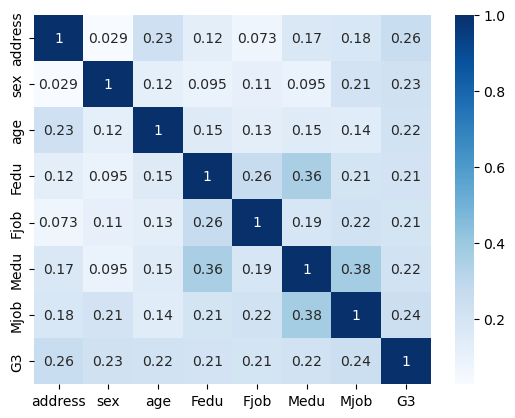

In [11]:
#indicate the variables
df = data_mat[['address','sex', 'age', 'Fedu', 'Fjob' ,'Medu', 'Mjob', 'G3']]

#Populate a correlation matrix
corr_matrix = pd.DataFrame(np.zeros((len(df.columns), len(df.columns))), columns=df.columns, index=df.columns)
for i, var1 in enumerate(df.columns):
    for j, var2 in enumerate(df.columns):
        corr_matrix.iloc[i, j] = cramers_v(df[var1], df[var2])

# plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.show()